In [57]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [3]:
!pip install ar_wordcloud transformers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from ar_wordcloud import ArabicWordCloud

from transformers import AutoTokenizer, AutoModelForSequenceClassification

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')

else:
    device = torch.device("cpu")
    print('using the CPU')

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 366 kB 41.0 MB/s 
     |████████████████████████████████| 6.5 MB 36.9 MB/s 
     |████████████████████████████████| 895 kB 37.9 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
There are 1 GPU(s) available.


**Read Two DataSets**

In [4]:
dialect_ids_only = pd.read_csv('./dialect_dataset.csv')
dialect_with_title  =  pd.read_json('./output.json')

In [5]:
dialect_with_title.head()

,ids,title
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [6]:
dialect_ids_only.head()

,id,dialect
0,1175358310087892992,IQ
1,1175416117793349632,IQ
2,1175450108898565888,IQ
3,1175471073770573824,IQ
4,1175496913145217024,IQ


**Merge Two Data Sets (dialect_data_with_posts, dialect_data_with_country) on Ids columns**

In [7]:
dialect_data = pd.merge(dialect_with_title,dialect_ids_only, left_on="ids", right_on="id").drop('id', axis=1)
dialect_data.head()

,ids,title,dialect
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي,IQ
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ


**View The Most Repeated Country Dialect**

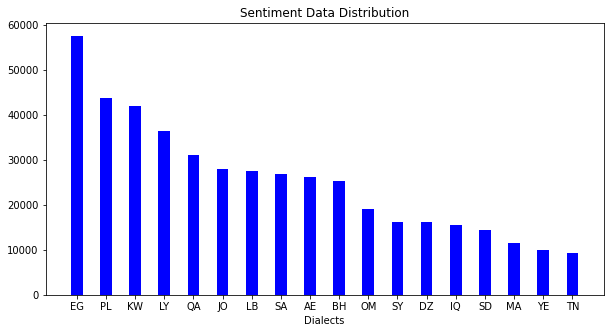

In [8]:
val_count = dialect_data.dialect.value_counts()
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(val_count.index,val_count.values, color ='blue',
        width = 0.4)
 
plt.xlabel("Dialects")

plt.title("Sentiment Data Distribution")
# plt.savefig('Sentiment_Data_Distribution".jpg')
plt.show()

**Preprocessing Steps:**


1.   Remove entity mentions (eg. '@united')
2.   Remove entity emoji (eg. '🌺')
3.   Correct errors (eg. '&amp;' to '&')



In [9]:
import unicodedata

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Remove entity emoji (eg. '🌺')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Normalize unicode encoding
    text = unicodedata.normalize('NFC', text)
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    #Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '<URL>', text)
    #Remove Emoji
    text = re.sub(re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030""]+", re.UNICODE),'',text)

    return text

In [10]:
#apply preprocessing on whole data
dialect_data.title = dialect_data.title.apply(lambda x: text_preprocessing(x))
dialect_data

,ids,title,dialect
0,1175358310087892992,لكن بالنهاية .. ينتفض .. يغير .,IQ
1,1175416117793349632,يعني هذا محسوب على البشر .. حيونه ووحشيه .. وت...,IQ
2,1175450108898565888,مبين من كلامه خليجي,IQ
3,1175471073770573824,يسلملي مرورك وروحك الحلوه,IQ
4,1175496913145217024,وين هل الغيبه اخ محمد,IQ
...,...,...,...
456734,732631587007959040,عطرك اللي ضمني لحظه لقاك،، ضيع الدنيا وضيعن...,BH
456735,733010187552952320,يا سلام خوش مكان,BH
456736,733090615991369728,اشتقت له بس ماودي احاكيه ابيه من كيفه ي ح ن وي...,BH
456737,733091262539149312,لـو قآلـو الناس مثله بـ العرب واجد بقـول محد غ...,BH


downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


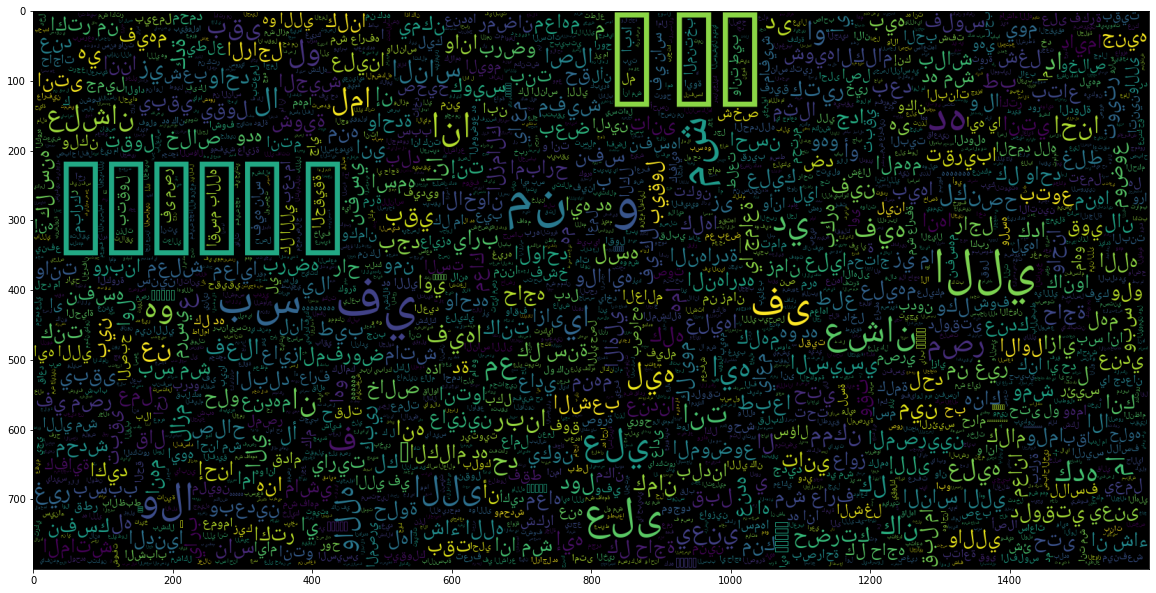

In [14]:
plt.figure(figsize = (20,20)) 
wc = ArabicWordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dialect_data[dialect_data.dialect == 'EG'].title))
plt.imshow(wc)

*   **Remove dialect columns that contain all countries**
*   **Change dialect columns from string to category then save in new column called targets** 
*   **splite data into train & test**




In [11]:
dialects = dialect_data['dialect'].astype('category')
print('categories: {}'.format(dialects.cat.categories.unique()))
targets = {k: v for v, k in enumerate(dialects.cat.categories.values)}
dialect_data['targets'] = dialect_data['dialect'].apply(lambda x : targets[x])
train, test =train_test_split(dialect_data, test_size=0.1, random_state=42)
# check dimintionality of data 
print('dim train: {}'.format(train.shape))
print('dim test: {}'.format(test.shape))
print('y_train description: \n{}'.format(train['targets'].describe()))
print('y_test description: \n{}'.format(test['targets'].describe()))
print('y_train counts: \n{}'.format(train['targets'].value_counts()))
print('y_test counts: \n{}'.format(test['targets'].value_counts()))

categories: Index(['AE', 'BH', 'DZ', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM', 'PL',
       'QA', 'SA', 'SD', 'SY', 'TN', 'YE'],
      dtype='object')
dim train: (411065, 4)
dim test: (45674, 4)
y_train description: 
count    411065.000000
mean          7.505151
std           4.651828
min           0.000000
25%           3.000000
50%           7.000000
75%          11.000000
max          17.000000
Name: targets, dtype: float64
y_test description: 
count    45674.000000
mean         7.483623
std          4.641097
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         17.000000
Name: targets, dtype: float64
y_train counts: 
3     51832
11    39330
6     37838
8     32812
12    27954
5     25018
7     24769
13    24090
0     23626
1     22764
10    17229
15    14647
2     14534
4     13965
14    13038
9     10383
17     8922
16     8314
Name: targets, dtype: int64
y_test counts: 
3     5746
11    4369
6     4228
8     3651
12    3083
5   

## Machine Learning Classical Approach
*   SVM
*   MultinomialNB



**Create train_model Function with two encoders**


*   CountVectorizer
*   TfidfTransformer
*   Save Model



In [16]:
import joblib

def train_model(model, data, targets, model_name):
    text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', model),
    ])
    text_clf.fit(data, targets)
    filename = f'{model_name}.joblib'
    joblib.dump(text_clf,filename)
    return text_clf

def get_accuracy(trained_model,X, y):
    predicted = trained_model.predict(X)
    accuracy = np.mean(predicted == y)
    return accuracy

## SVM Model 

In [17]:
from sklearn.svm import LinearSVC
trained_clf_SVC = train_model(LinearSVC(), train['title'],train['targets'], 'svm_model')
accuracy = get_accuracy(trained_clf_SVC,test['title'],test['targets'])
print(f"Test dataset accuracy with SVC: {accuracy:.2f}")

Test dataset accuracy with SVC: 0.55


`**Load Model and Create Predictions**

In [12]:
print(test['title'][:6])

print(test['targets'][:6])

158730    زياره عائليه بالرغم من انهم مش مودي هدول الزيا...
368442                  ايه بس هو بطه مايدخل يدش وانا ضعيف 
292087    واحد ركن عربيته تحت العمارة ولما نزل لقيها بال...
276039    ده بداية العام الدراسي كل سنه وانتى طيبه خللى ...
204983    اتوقع استراحة محارب و بكرة راح تشوفينه مشعلل م...
309997                                  مش فهمانة شي خبيصة 
Name: title, dtype: object
158730     5
368442     6
292087     3
276039     3
204983    13
309997     7
Name: targets, dtype: int64


In [19]:
loaded_model = joblib.load('svm_model.joblib')
loaded_model.predict(test['title'][:6])

array([3, 6, 3, 3, 1, 7])

## Naive Bayez Model

In [20]:
from sklearn.naive_bayes import MultinomialNB
trained_clf_multinomial_nb = train_model(MultinomialNB(), train['title'],train['targets'], 'naive_bayes_model')
accuracy = get_accuracy(trained_clf_multinomial_nb,test['title'],test['targets'])
print(f"Test dataset accuracy with MultinomialNB: {accuracy:.2f}")

Test dataset accuracy with MultinomialNB: 0.40


`**Load Model and Create Predictions**

In [21]:
loaded_model = joblib.load('naive_bayes_model.joblib')
loaded_model.predict(test['title'][:6])

array([3, 3, 3, 3, 6, 7])

## Deep Learning Approach (RNN --transfer learning)

In [21]:
#load Arabic Tokenizer
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/297k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

**Create Dataset loader class:** 
handle data and send it as batches

In [46]:
TEXT_MAX_LEN = 70

class MyDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame = dialect_data,
        tokenizer = tokenizer,
        text_max_token_len: int = TEXT_MAX_LEN,
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['title']

        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        target = data_row['targets']
        
        return dict(
            input_ids=text_encoding['input_ids'].flatten(),
            attention_mask=text_encoding['attention_mask'].flatten(),
            target=torch.tensor(target, dtype=torch.long),
        )

In [14]:
class CustomAraBERTModel(nn.Module):
    def __init__(self):
        super(CustomAraBERTModel, self).__init__()
        self.arabert = AutoModelForSequenceClassification.from_pretrained(
            "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
        )
        self.arabert.classifier = nn.Linear(in_features=768, out_features=18, bias=True)

    def forward(self, input_ids, attention_mask):
        output = self.arabert(input_ids, attention_mask=attention_mask)
        return output

In [25]:
#send data to loader class
train_dataset = MyDataset(train, tokenizer)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128)

test_dataset = MyDataset(test, tokenizer)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=128)

In [26]:
#start training

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomAraBERTModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 1

num_training_steps = num_epochs * len(train_dataloader)
progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(batch['input_ids'], batch['attention_mask'])
        logits = outputs.logits
        loss = criterion(logits, batch['target'])
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        progress_bar.update()
    
    torch.save(model, './arabert_dialect.pth')
    print(f'epoch: {epoch} -- loss: {loss}')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

  0%|          | 0/3212 [00:00<?, ?it/s]

epoch: 0 -- loss: 1.3744622468948364


**RNN Predictions**

In [88]:
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =torch.load(Path("./arabert_dialect.pth"), map_location=device)
predict = MyDataset(test[0:1], tokenizer)
predict_dataloader = DataLoader(predict, shuffle=True, batch_size=1)


for batch in predict_dataloader:

  batch = {k: v.to(device) for k, v in batch.items()}
        
  outputs = model(batch['input_ids'], batch['attention_mask'])
  print(int(torch.argmax(outputs.logits[0])))
  # prediction = int(torch.max(outputs.logits[0], 1).numpy())
  # prediction

11
